# Quantitative Risk Management Assignment

## Import Libraries and Setup

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import os, json, pathlib
import kagglehub
from pathlib import Path
import re

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


## Load Data, Preprocessing, and First Look

In [3]:
# Load dataset from Kaggle and save as df
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")
base = Path(path)
df = pd.read_csv(base / "UCI_Credit_Card.csv")

In [4]:
print(f'Rows: {df.shape[0]}, Columns: {df.shape[1]}')

Rows: 30000, Columns: 25


In [5]:
display(df.head())

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [6]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [7]:
df.isnull().sum().sort_values()

ID                            0
PAY_AMT5                      0
PAY_AMT4                      0
PAY_AMT3                      0
PAY_AMT2                      0
PAY_AMT1                      0
BILL_AMT6                     0
BILL_AMT5                     0
BILL_AMT4                     0
BILL_AMT3                     0
BILL_AMT2                     0
PAY_AMT6                      0
BILL_AMT1                     0
PAY_5                         0
PAY_4                         0
PAY_3                         0
PAY_2                         0
PAY_0                         0
AGE                           0
MARRIAGE                      0
EDUCATION                     0
SEX                           0
LIMIT_BAL                     0
PAY_6                         0
default.payment.next.month    0
dtype: int64

In [8]:
# Change column name of target variable
df = df.rename(columns={"default.payment.next.month": "default"})
df.columns = [re.sub(r"[^\w]", "_", c).strip("_").lower() for c in df.columns]

# Check if target variable has only 0 and 1 values
assert set(df['default'].unique()) == {0, 1}

# Simple check of class counts
df['default'].value_counts().sort_index()

default
0    23364
1     6636
Name: count, dtype: int64

In [9]:
# Sex
df['sex'].value_counts(dropna=False).sort_index()

sex
1    11888
2    18112
Name: count, dtype: int64

In [10]:
# Education
df['education'].value_counts(dropna=False).sort_index()

education
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64

In [11]:
# Mapping education values 0, 5, 6 to 7 (unknown) (others remain unchanged)
edu_map = {0: 7, 5: 7, 6: 7}
df["education"] = df["education"].replace(edu_map).astype("int64")
print(df["education"].value_counts().sort_index())

education
1    10585
2    14030
3     4917
4      123
7      345
Name: count, dtype: int64


In [12]:
# Marriage
df['marriage'].value_counts(dropna=False).sort_index()

marriage
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64

In [13]:
# Payment status columns
for c in [col for col in df.columns if re.fullmatch(r"pay_[0-6]", col)]:
    print(f"\n{c}:\n{df[c].value_counts(dropna=False).sort_index()}")


pay_0:
pay_0
-2     2759
-1     5686
 0    14737
 1     3688
 2     2667
 3      322
 4       76
 5       26
 6       11
 7        9
 8       19
Name: count, dtype: int64

pay_2:
pay_2
-2     3782
-1     6050
 0    15730
 1       28
 2     3927
 3      326
 4       99
 5       25
 6       12
 7       20
 8        1
Name: count, dtype: int64

pay_3:
pay_3
-2     4085
-1     5938
 0    15764
 1        4
 2     3819
 3      240
 4       76
 5       21
 6       23
 7       27
 8        3
Name: count, dtype: int64

pay_4:
pay_4
-2     4348
-1     5687
 0    16455
 1        2
 2     3159
 3      180
 4       69
 5       35
 6        5
 7       58
 8        2
Name: count, dtype: int64

pay_5:
pay_5
-2     4546
-1     5539
 0    16947
 2     2626
 3      178
 4       84
 5       17
 6        4
 7       58
 8        1
Name: count, dtype: int64

pay_6:
pay_6
-2     4895
-1     5740
 0    16286
 2     2766
 3      184
 4       49
 5       13
 6       19
 7       46
 8        2
Name: count, dtype

In [14]:
# Bill amount columns
bill_cols = [c for c in df.columns if re.fullmatch(r"bill_amt[1-6]", c)]
df[bill_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
bill_amt1,30000.0,51223.330900,73635.860576,-165580.0,3558.75,22381.5,67091.00,964511.0
bill_amt2,30000.0,49179.075167,71173.768783,-69777.0,2984.75,21200.0,64006.25,983931.0
bill_amt3,30000.0,47013.154800,69349.387427,-157264.0,2666.25,20088.5,60164.75,1664089.0
bill_amt4,30000.0,43262.948967,64332.856134,-170000.0,2326.75,19052.0,54506.00,891586.0
bill_amt5,30000.0,40311.400967,60797.155770,-81334.0,1763.00,18104.5,50190.50,927171.0
bill_amt6,30000.0,38871.760400,59554.107537,-339603.0,1256.00,17071.0,49198.25,961664.0


In [15]:
# Pay amount columns
pay_amt_cols = [c for c in df.columns if re.fullmatch(r"pay_amt[1-6]", c)]
df[pay_amt_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
pay_amt1,30000.0,5663.580500,16563.280354,0.0,1000.00,2100.0,5006.00,873552.0
pay_amt2,30000.0,5921.163500,23040.870402,0.0,833.00,2009.0,5000.00,1684259.0
pay_amt3,30000.0,5225.681500,17606.961470,0.0,390.00,1800.0,4505.00,896040.0
pay_amt4,30000.0,4826.076867,15666.159744,0.0,296.00,1500.0,4013.25,621000.0
pay_amt5,30000.0,4799.387633,15278.305679,0.0,252.50,1500.0,4031.50,426529.0
pay_amt6,30000.0,5215.502567,17777.465775,0.0,117.75,1500.0,4000.00,528666.0


In [16]:
# One hot encoding for categorical variables
sex_dummies = pd.get_dummies(df["sex"], prefix="sex")
marriage_dummies = pd.get_dummies(df["marriage"], prefix="marriage")
edu_dummies = pd.get_dummies(df["education"], prefix="education")

# Concatenate dummy variables to the dataframe
df = pd.concat([df, sex_dummies, marriage_dummies, edu_dummies], axis=1)

# Drop original categorical columns and one dummy from each group to avoid multicollinearity
df = df.drop(columns=["sex", "sex_2", "education", "education_7", "marriage", "marriage_3"])

df.head()


,id,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt6,default,sex_1,marriage_0,marriage_1,marriage_2,education_1,education_2,education_3,education_4
0,1,20000.0,24,2,2,-1,-1,-2,-2,3913.0,...,0.0,1,False,False,True,False,False,True,False,False
1,2,120000.0,26,-1,2,0,0,0,2,2682.0,...,2000.0,1,False,False,False,True,False,True,False,False
2,3,90000.0,34,0,0,0,0,0,0,29239.0,...,5000.0,0,False,False,False,True,False,True,False,False
3,4,50000.0,37,0,0,0,0,0,0,46990.0,...,1000.0,0,False,False,True,False,False,True,False,False
4,5,50000.0,57,-1,0,-1,0,0,0,8617.0,...,679.0,0,True,False,True,False,False,True,False,False


## Feature Engineering

In [17]:
pay_cols = ["pay_0", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6"]
bill_cols = ["bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6"]

# Features based on payment status
df["max_late_payment"] = df[pay_cols].max(axis=1)
df["num_late_payments"] = (df[pay_cols] > 0).sum(axis=1)
df["recent_late_payment"] = (df["pay_0"] > 0).astype(int)
df["delay_trend_overall"] = df["pay_0"].clip(lower=0) - df["pay_6"].clip(lower=0)
df["delay_trend_short_term"] = df["pay_0"].clip(lower=0) - df["pay_3"].clip(lower=0)
df["num_fully_paid"] = (df[pay_cols] == -1).sum(axis=1)
df["num_inactive_months"] = (df[pay_cols] == -2).sum(axis=1)

# Features based on payment amounts
df["pay_volatility"] = df[pay_amt_cols].std(axis=1)

# Max consecutive late payments in a row
df["max_consecutive_delays"] = df[pay_cols].apply(
    lambda x: max((x > 0).astype(int).groupby((x <= 0).cumsum()).sum()),
    axis=1)

# Features based on bill amounts
df["bill_mean"] = df[bill_cols].mean(axis=1)
df["bill_std"] = df[bill_cols].std(axis=1)
df["bill_trend"] = df["bill_amt1"] - df["bill_amt6"]

In [33]:
# Outlier diagbnostics for key numeric features

outlier_features = ["limit_bal", "bill_mean"]

# Show upper quantiles for these features
df[outlier_features].quantile([0.95, 0.99, 0.995, 0.999])

,limit_bal,bill_mean
0.950,430000.0,174403.675000
0.990,500000.0,300287.333419
0.995,500000.0,300287.341933
0.999,500000.0,300287.341933


In [ ]:
# Clip to 0.99 quantile to reduce the influence of extreme values in coefficient estimation in logistic regression
for col in outlier_features:
     upper_clip = df[col].quantile(0.99)
     df[col] = df[col].clip(upper=upper_clip)

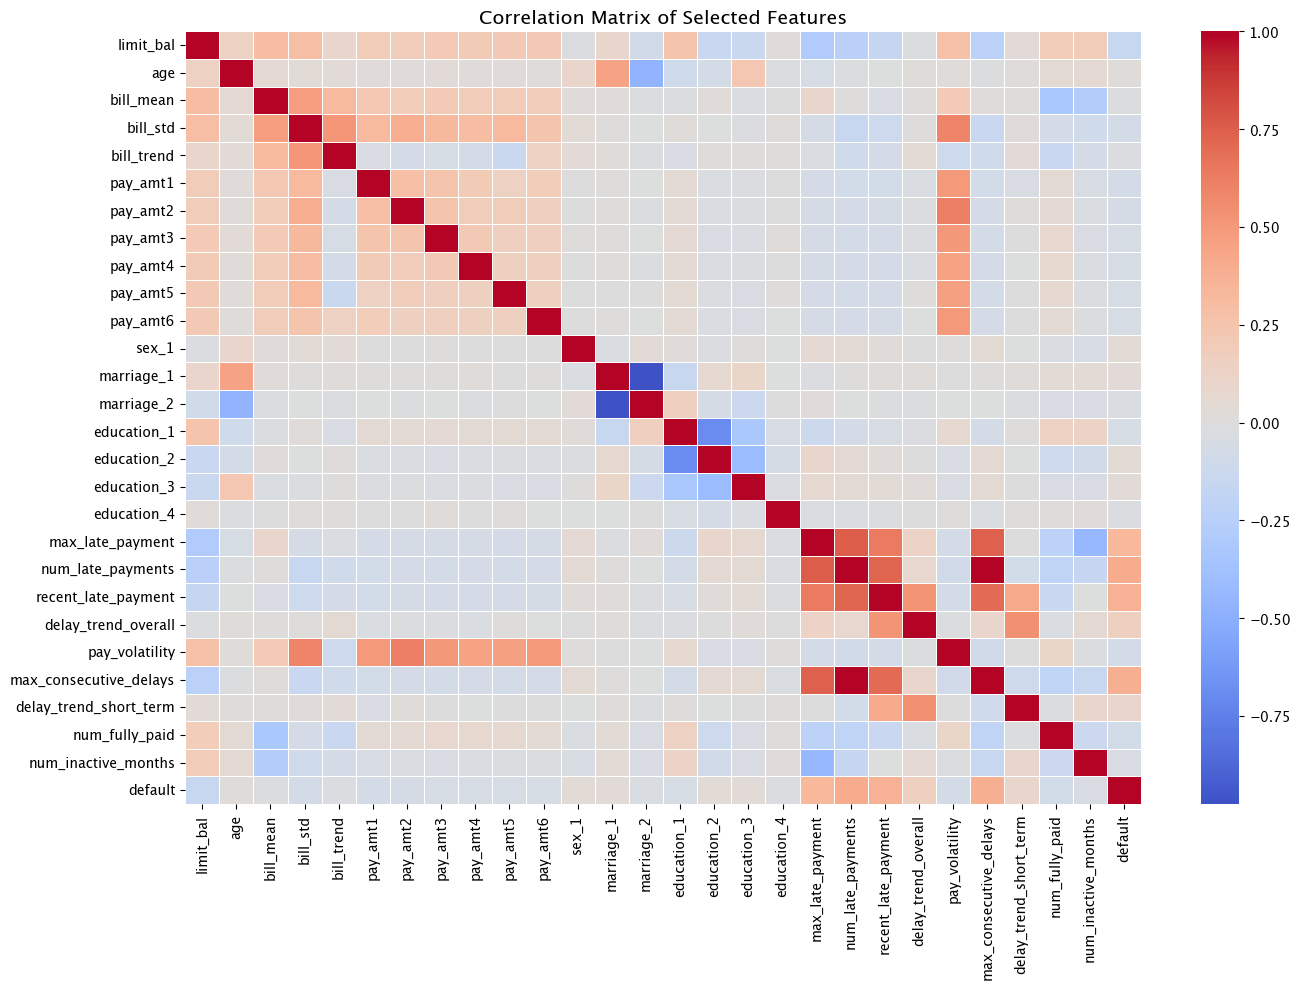

In [ ]:
## Correlation Matrix of Selected Features

feature_cols = [
    "limit_bal", "age", "bill_mean", "bill_std", "bill_trend",
    "pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6",
    "sex_1", "marriage_1", "marriage_2",
    "education_1", "education_2", "education_3", "education_4",
    "max_late_payment", "num_late_payments", "recent_late_payment",
    "delay_trend_overall", "pay_volatility", "max_consecutive_delays",
    "delay_trend_short_term", "num_fully_paid", "num_inactive_months"]

corr_features = feature_cols + ["default"]
corr = df[corr_features].corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.5)

plt.title("Correlation Matrix of Selected Features", fontsize=14)
plt.tight_layout()
plt.show()

# High correlation in some features, but small experiments showed that they improve
# accuracy for logistic regression when we use regularisation.
# Regularisation will help to shrink coefficients of correlated features.

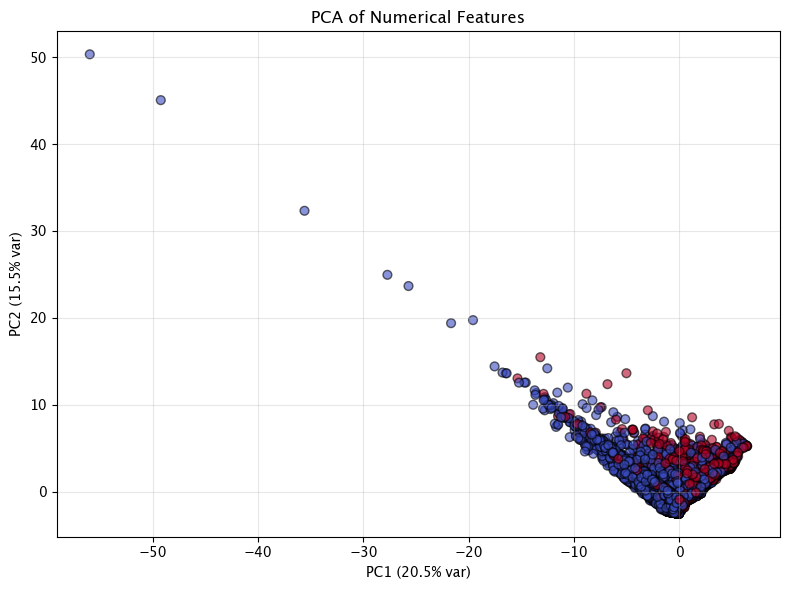

Explained variance ratio: 36.01% (2 components)


In [20]:
# PCA as exploratory step (not used for modeling)

numeric_features = [
    "limit_bal", "age", "bill_mean", "bill_std", "bill_trend",
    "pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6",
    "max_late_payment", "num_late_payments", "recent_late_payment",
    "delay_trend_overall", "pay_volatility", "max_consecutive_delays",
    "delay_trend_short_term", "num_fully_paid", "num_inactive_months"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_features])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df["default"],
    cmap="coolwarm",
    alpha=0.6,
    edgecolors="k",
    s=40)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of Numerical Features")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum()*100:.2f}% (2 components)")



- In the 2D PCA plot, default and non-default customers are heavily overlapping.  
  This suggests that our numerical features do not create a linearly separable structure.
- There seems to be a spectrum of behaviours rather than clear, distinct groups.
- The explained variance of the first two components is moderate.  
  This means the feature space is high-dimensional and there is no single dominant factor.
- For modelling, this implies that we cannot expect very high performance from simple linear
  decision boundaries. We will need models that can capture non-linear structure.
- Even with good modelling and feature engineering, default prediction in this dataset is likely
  to remain a noisy problem, so we should also focus on threshold tuning rather than expecting
  perfect separation.

## Exploratory Data Analysis

In [21]:
# Define themes and consistent colors
sns.set_theme(style="whitegrid")

color_non_default = "steelblue"
color_default = "grey"

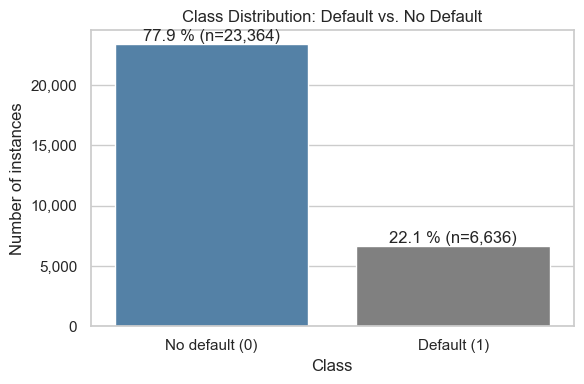

In [22]:
counts = df["default"].value_counts().sort_index()
pcts = (df["default"].value_counts(normalize=True).sort_index().mul(100).round(1))

labels = ["No default (0)", "Default (1)"]

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=labels, y=counts.values, palette=[color_non_default, color_default], hue=labels, legend=False)
ax.set_xlabel("Class")
ax.set_ylabel("Number of instances")
ax.set_title("Class Distribution: Default vs. No Default")

# Format y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

for i, (n, p) in enumerate(zip(counts.values, pcts.values)):
    ax.text(i, n, f"{p} % (n={n:,})", ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [40]:
# Naive baseline class imbalance

class_counts = df["default"].value_counts().sort_index()
class_pcts = (class_counts / len(df)).round(3)

naive_majority_rate = class_pcts[0]
print(f"\nNaive majority baseline accuracy (always predict 0): {naive_majority_rate:.3f}")


Naive majority baseline accuracy (always predict 0): 0.779


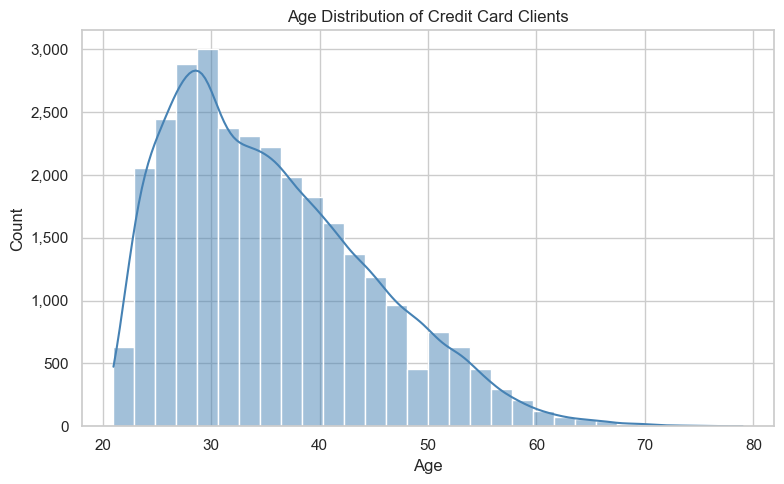

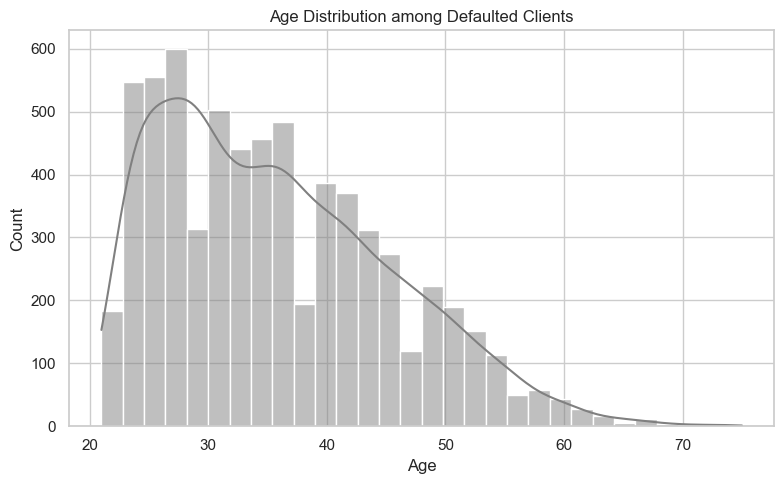

In [23]:
# Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["age"], bins=30, kde=True, color=color_non_default)
plt.title("Age Distribution of Credit Card Clients")
plt.xlabel("Age")
plt.ylabel("Count")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout()
plt.show()

df_default = df[df["default"] == 1]

plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_default,
    x="age",
    bins=30,
    kde=True,
    color=color_default)

plt.title("Age Distribution among Defaulted Clients")
plt.xlabel("Age")
plt.ylabel("Count")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout()
plt.show()

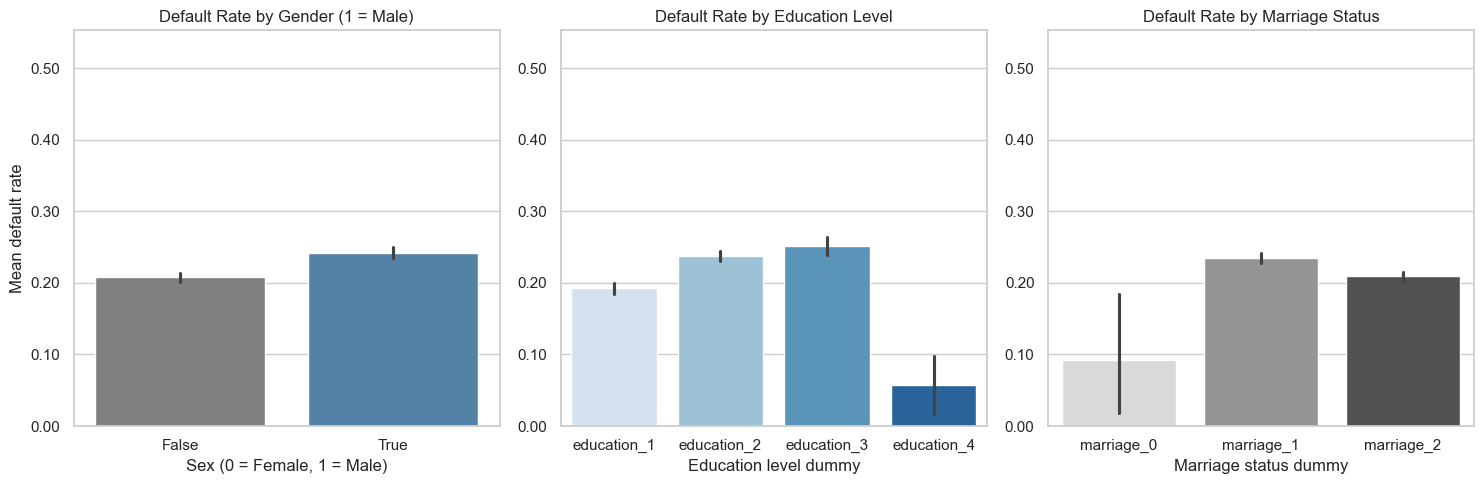

In [ ]:
# Default Rate by Gender, Education and Marriage

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gender
sns.barplot(
    data=df,
    x="sex_1",
    y="default",
    estimator=lambda x: np.mean(x),
    hue="sex_1",
    palette=[color_default, color_non_default],
    legend=False,
    ax=axes[0])

axes[0].set_title("Default Rate by Gender (1 = Male)")
axes[0].set_xlabel("Sex (0 = Female, 1 = Male)")
axes[0].set_ylabel("Mean default rate")
axes[0].set_ylim(0, df["default"].mean() * 2.5)

# Education
edu_cols = [col for col in df.columns if col.startswith("education_")]
edu_long = df.melt(
    id_vars=["default"],
    value_vars=edu_cols,
    var_name="education_level",
    value_name="is_member")
edu_long = edu_long[edu_long["is_member"] == 1]

sns.barplot(
    data=edu_long,
    x="education_level",
    y="default",
    estimator=lambda x: np.mean(x),
    palette="Blues",
    hue="education_level",
    legend=False,
    ax=axes[1])

axes[1].set_title("Default Rate by Education Level")
axes[1].set_xlabel("Education level dummy")
axes[1].set_ylabel("")
axes[1].set_ylim(0, df["default"].mean() * 2.5)

# Marriage
mar_cols = [col for col in df.columns if col.startswith("marriage_")]
mar_long = df.melt(
    id_vars=["default"],
    value_vars=mar_cols,
    var_name="marriage_status",
    value_name="is_member")
mar_long = mar_long[mar_long["is_member"] == 1]

sns.barplot(
    data=mar_long,
    x="marriage_status",
    y="default",
    estimator=lambda x: np.mean(x),
    palette="Greys",
    hue="marriage_status",
    legend=False,
    ax=axes[2])

axes[2].set_title("Default Rate by Marriage Status")
axes[2].set_xlabel("Marriage status dummy")
axes[2].set_ylabel("")
axes[2].set_ylim(0, df["default"].mean() * 2.5)

# Format y-axis
for ax in axes:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

plt.tight_layout()
plt.show()


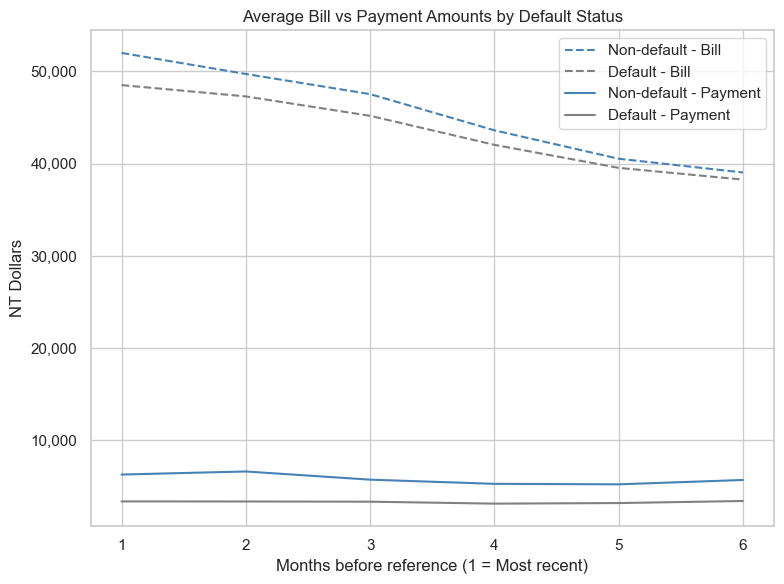

In [26]:
# Average Bill vs Payment Amounts by Default Status
months = np.arange(1, 7)

bill_cols = [f"bill_amt{i}" for i in range(1, 7)]
pay_cols = [f"pay_amt{i}" for i in range(1, 7)]

mean_bill = df.groupby("default")[bill_cols].mean().T
mean_pay = df.groupby("default")[pay_cols].mean().T

plt.figure(figsize=(8, 6))

# Bills
plt.plot(months, mean_bill.loc[bill_cols, 0], "--", label="Non-default - Bill", color=color_non_default)
plt.plot(months, mean_bill.loc[bill_cols, 1], "--", label="Default - Bill", color=color_default)

# Payments
plt.plot(months, mean_pay.loc[pay_cols, 0], "-", label="Non-default - Payment", color=color_non_default)
plt.plot(months, mean_pay.loc[pay_cols, 1], "-", label="Default - Payment", color=color_default)

plt.title("Average Bill vs Payment Amounts by Default Status")
plt.xlabel("Months before reference (1 = Most recent)")
plt.ylabel("NT Dollars")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.legend()
plt.tight_layout()
plt.show()


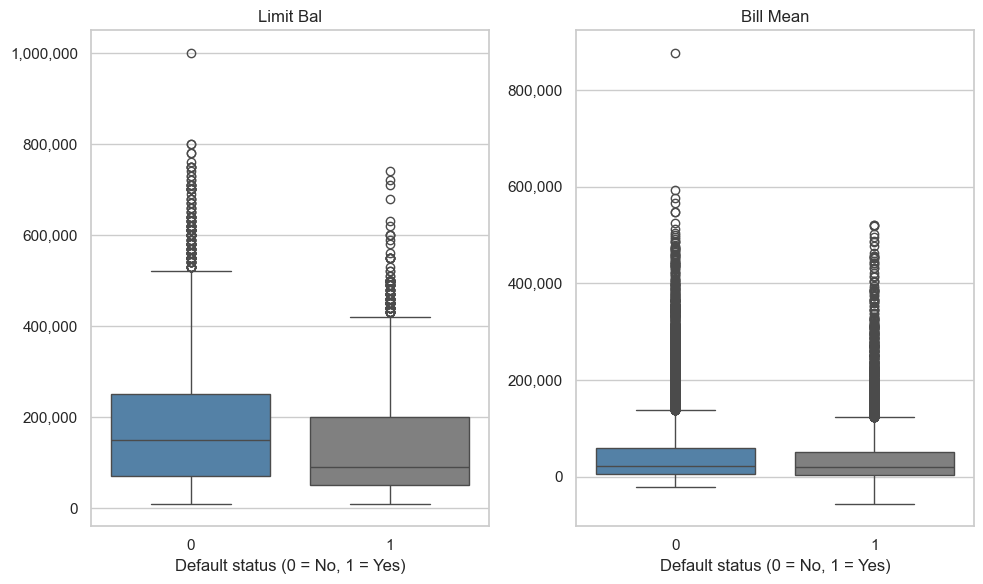

In [27]:
# Boxplots for key numeric features that are likely to have outliers

features = ["limit_bal", "bill_mean"]

plt.figure(figsize=(10, 6))
for i, col in enumerate(features, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(
        data=df,
        x="default",
        y=col,
        palette=[color_non_default, color_default],
        hue="default",
        legend=False,
        showfliers=True)
    
    plt.title(col.replace("_", " ").title())
    plt.xlabel("Default status (0 = No, 1 = Yes)")
    plt.ylabel("")
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.tight_layout()
plt.show()

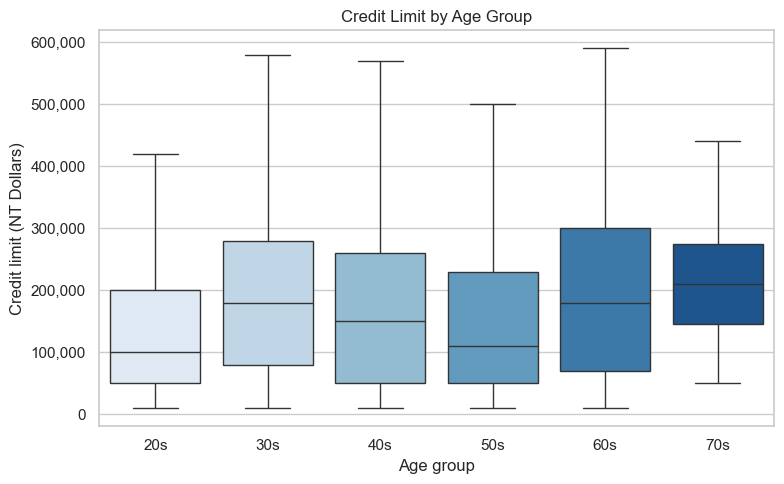

In [28]:
# Credit Limit by Age Group
df["age_group"] = pd.cut(
    df["age"],
    bins=[20, 30, 40, 50, 60, 70, 80],
    labels=["20s", "30s", "40s", "50s", "60s", "70s"])

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="age_group",
    y="limit_bal",
    palette="Blues",
    hue="age_group",
    legend=False,
    showfliers=False)

plt.title("Credit Limit by Age Group")
plt.xlabel("Age group")
plt.ylabel("Credit limit (NT Dollars)")

formatter = FuncFormatter(lambda x, _: f"{int(x):,}")
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

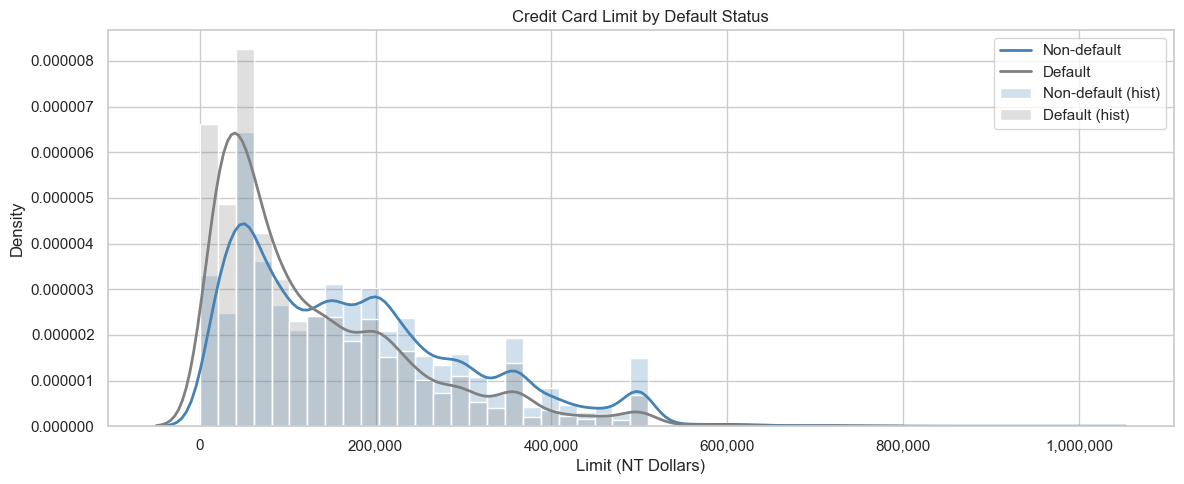

In [29]:
## Distribution of Credit Limit by Default Status

plt.figure(figsize=(12, 5))

bins = np.linspace(0, df["limit_bal"].max(), 50)

# Non-default
sns.histplot(
    df.loc[df["default"] == 0, "limit_bal"],
    bins=bins,
    stat="density",
    color=color_non_default,
    alpha=0.25,
    label="Non-default (hist)")
sns.kdeplot(
    df.loc[df["default"] == 0, "limit_bal"],
    color=color_non_default,
    lw=2,
    label="Non-default")

# Default
sns.histplot(
    df.loc[df["default"] == 1, "limit_bal"],
    bins=bins,
    stat="density",
    color=color_default,
    alpha=0.25,
    label="Default (hist)")
sns.kdeplot(
    df.loc[df["default"] == 1, "limit_bal"],
    color=color_default,
    lw=2,
    label="Default")

plt.title("Credit Card Limit by Default Status")
plt.xlabel("Limit (NT Dollars)")
plt.ylabel("Density")

x_formatter = FuncFormatter(lambda x, _: f"{int(x):,}")
plt.gca().xaxis.set_major_formatter(x_formatter)
plt.ticklabel_format(axis="y", style="plain")

plt.legend()
plt.tight_layout()
plt.show()



/var/folders/lb/79xd__4j6qg1_gm96zqr1zjw0000gn/T/ipykernel_3580/149663000.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("num_late_bin")["default"]


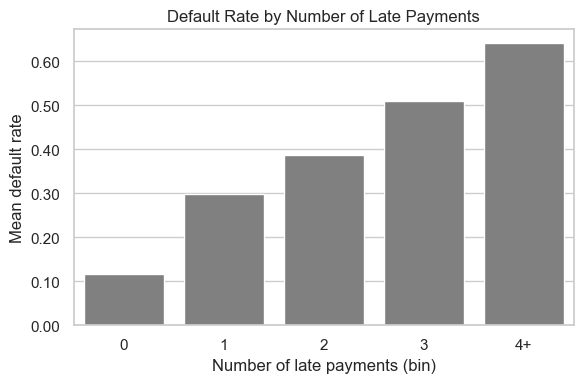

In [38]:
## Default rate by number of late payments (binned)

# Create simple bins for number of late payments
df["num_late_bin"] = pd.cut(
    df["num_late_payments"],
    bins=[-1, 0, 1, 2, 3, 10],
    labels=["0", "1", "2", "3", "4+"],
)

late_default_rate = (
    df.groupby("num_late_bin")["default"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=late_default_rate,
    x="num_late_bin",
    y="default",
    color=color_default)

ax.set_title("Default Rate by Number of Late Payments")
ax.set_xlabel("Number of late payments (bin)")
ax.set_ylabel("Mean default rate")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))
plt.tight_layout()
plt.show()

df.drop(columns=["num_late_bin"], inplace=True) 

## Modeling

In [41]:
# Train-Test Split and Scaling

y = df["default"].astype("int64")
X = df[feature_cols]

# Stratified split to keep class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Scale only numeric features
scale_cols = numeric_features

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])


### Logistic Regression (class_weight = 'balanced')

In [ ]:
# Define model
log_reg = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    solver="liblinear",
    random_state=42)

# Define parameter grid for tuning
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"]}

# Grid search with 5-fold CV
grid_log = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1)

# Fit on scaled training data
grid_log.fit(X_train_scaled, y_train)

# Best parameters and CV AUC
print("Best parameters:", grid_log.best_params_)
print("Best CV AUC:", grid_log.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'C': 10, 'penalty': 'l2'}
Best CV AUC: 0.7703705554118161


Test AUC: 0.7529565457321808

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.84      4673
           1       0.46      0.59      0.52      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.78      0.76      0.77      6000

Confusion Matrix:
 [[3754  919]
 [ 538  789]]


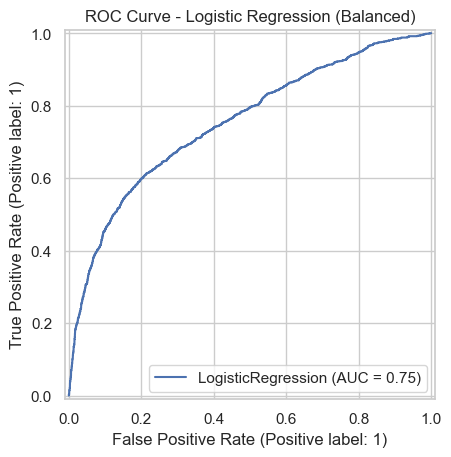

In [43]:
# Evaluate on test set
y_pred = grid_log.best_estimator_.predict(X_test_scaled)
y_pred_proba = grid_log.best_estimator_.predict_proba(X_test_scaled)[:, 1]

test_auc = roc_auc_score(y_test, y_pred_proba)
print("Test AUC:", test_auc)

# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
RocCurveDisplay.from_estimator(grid_log.best_estimator_, X_test_scaled, y_test)
plt.title("ROC Curve - Logistic Regression (Balanced)")
plt.show()

### Logistic Regression (with SMOTE)

In [ ]:
# Apply SMOTE only on the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_smote))

# Define model
log_reg_smote = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
    random_state=42)

# Define parameter grid
param_grid_smote = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"]}

# Grid search with 5-fold CV
grid_log_smote = GridSearchCV(
    estimator=log_reg_smote,
    param_grid=param_grid_smote,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1)

# Fit model on SMOTE-balanced training data
grid_log_smote.fit(X_train_smote, y_train_smote)

# Best parameters and CV AUC
print("Best parameters:", grid_log_smote.best_params_)
print("Best CV AUC:", grid_log_smote.best_score_)

Before SMOTE: [18691  5309]
After SMOTE: [18691 18691]
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'C': 10, 'penalty': 'l1'}
Best CV AUC: 0.8033084101919149


Test AUC: 0.7506417842982285

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.85      4673
           1       0.48      0.58      0.53      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.77      0.78      6000

Confusion Matrix:
 [[3846  827]
 [ 560  767]]


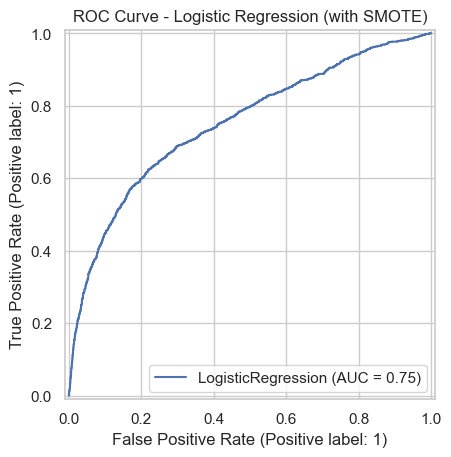

In [45]:
# Evaluate on original test set (not oversampled)
y_pred_smote = grid_log_smote.best_estimator_.predict(X_test_scaled)
y_pred_proba_smote = grid_log_smote.best_estimator_.predict_proba(X_test_scaled)[:, 1]

test_auc_smote = roc_auc_score(y_test, y_pred_proba_smote)
print("Test AUC:", test_auc_smote)

# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))

# ROC Curve
RocCurveDisplay.from_estimator(grid_log_smote.best_estimator_, X_test_scaled, y_test)
plt.title("ROC Curve - Logistic Regression (with SMOTE)")
plt.show()

### Random forest classifier (bagging)

In [ ]:
# Define model
rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",   # handle class imbalance internally
    n_jobs=-1)

# Define parameter grid
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5]}

# Grid search with 5-fold CV using AUC
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1)

# Fit model on unscaled data as trees don't require scaling
grid_rf.fit(X_train, y_train)

# Best parameters and CV AUC
print("Best parameters:", grid_rf.best_params_)
print("Best CV AUC:", grid_rf.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best CV AUC: 0.7839473928737133


Test AUC: 0.7728766530813791

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.86      4673
           1       0.51      0.57      0.54      1327

    accuracy                           0.78      6000
   macro avg       0.69      0.71      0.70      6000
weighted avg       0.79      0.78      0.79      6000

Confusion Matrix:
 [[3933  740]
 [ 565  762]]


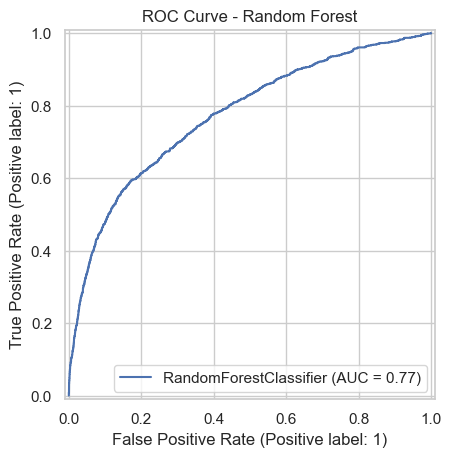

In [48]:
# Evaluate on test set
y_pred_rf = grid_rf.best_estimator_.predict(X_test)
y_pred_proba_rf = grid_rf.best_estimator_.predict_proba(X_test)[:, 1]

test_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print("Test AUC:", test_auc_rf)

# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# ROC Curve
RocCurveDisplay.from_estimator(grid_rf.best_estimator_, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

### XGBoost classifier (boosting)

In [ ]:
# Define model
xgb = XGBClassifier(
    random_state=42,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # balance classes
    eval_metric="logloss",
    n_jobs=-1)

# Define simple parameter grid
param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 8],
    "learning_rate": [0.01, 0.1, 0.2]}

# Grid search with 5-fold CV using AUC
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1)

# Fit model (on unscaled data, trees are scale-invariant)
grid_xgb.fit(X_train, y_train)

# Best parameters and CV AUC
print("Best parameters:", grid_xgb.best_params_)
print("Best CV AUC:", grid_xgb.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best CV AUC: 0.7840151244093335


Test AUC: 0.7753724316331808

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      4673
           1       0.46      0.64      0.53      1327

    accuracy                           0.75      6000
   macro avg       0.67      0.71      0.68      6000
weighted avg       0.79      0.75      0.77      6000

Confusion Matrix:
 [[3673 1000]
 [ 482  845]]


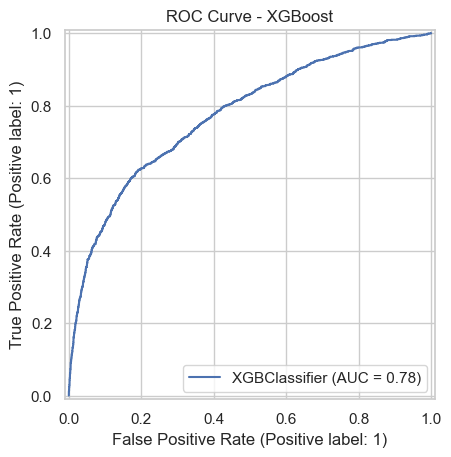

In [52]:
# Evaluate on test set
y_pred_xgb = grid_xgb.best_estimator_.predict(X_test)
y_pred_proba_xgb = grid_xgb.best_estimator_.predict_proba(X_test)[:, 1]

test_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print("Test AUC:", test_auc_xgb)

# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# ROC Curve
RocCurveDisplay.from_estimator(grid_xgb.best_estimator_, X_test, y_test)
plt.title("ROC Curve - XGBoost")
plt.show()

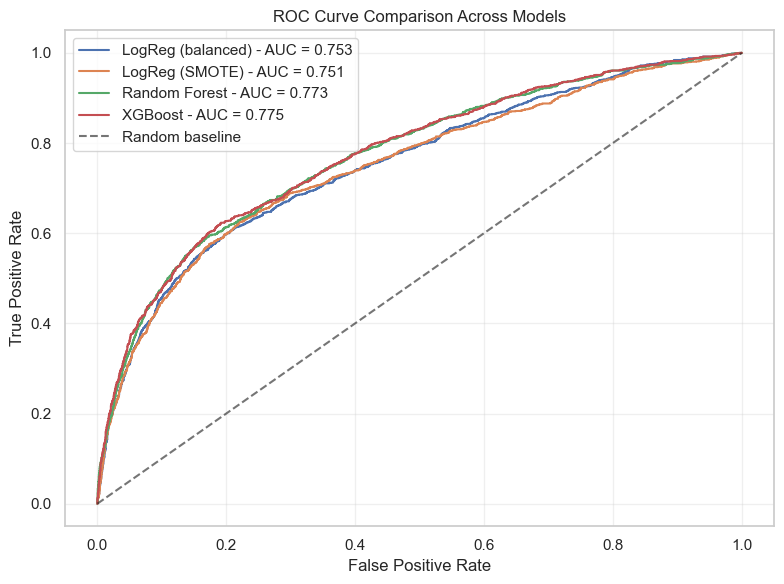

In [56]:
# Combined ROC curves for model comparison

plt.figure(figsize=(8, 6))

# Logistic regression (balanced)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (balanced) - AUC = {test_auc:.3f}")

# Logistic regression (SMOTE)
fpr_sm, tpr_sm, _ = roc_curve(y_test, y_pred_proba_smote)
plt.plot(fpr_sm, tpr_sm, label=f"LogReg (SMOTE) - AUC = {test_auc_smote:.3f}")

# Random forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest - AUC = {test_auc_rf:.3f}")

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost - AUC = {test_auc_xgb:.3f}")

# Baseline
plt.plot([0, 1], [0, 1], "k--", alpha=0.6, label="Random baseline")

plt.title("ROC Curve Comparison Across Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()